# <center> **CS 565, Spring 2022, Homework 1**
### <center> Due **Tues March 1, 11:59 pm ET (Boston time)**, via Gradescope




###**Submission guidelines** 
Please write your solutions inside of this .ipynb file, then convert it to a PDF before submitting on Gradescope:

*   **In Jupyter:** File > Download as > PDF
*   **In Google Colab:** File > Print > Destination > Save as PDF

When you submit, please **be sure to match the answers on your PDF to the outline on Gradescope.** In other words, if the answer to problem 2.1 is on pages 2 and 3 of your PDF, please be sure to select those pages as the answer to problem 2.1 on Gradescope. Since it takes significantly longer to grade homework that is not properly matched, **we may deduct points** for noncompliant submissions.

Andrew (the TF) will cover how to get started with the notebooks for writing problem solutions and running experiments. 

<div style="page-break-after: always;"></div>

## 1. 1-d clustering (20 points) 

Consider a set of $n$ $1$-dimensional points $X = \{x_1,\ldots , x_n\}$. Assume you want to partition them into $k$ clusters $C_1,C_2,\ldots , C_k$ (where
$k$ is part of the input) such that you **minimize** the following objective:

$$
F(C_1,\ldots , C_k) = \sum_{\ell = 1,\ldots , k}R(C_\ell),
$$
where for every cluster $C_\ell$
$$
R(C_\ell) = r_{\ell}^{\max} - r_\ell^{\min},
$$
and $r_{\ell}^{\max}=\arg\max_{x_i\in C_\ell} x_i$
and $r_{\ell}^{\min}=\arg\min_{x_i\in C_\ell} x_i$.


Design a polynomial-time algorithm that finds the optimal clustering in linear time.

**Solution:**
Split the data at k-1 biggest gaps(distance between two consecutive data points).

**Algorithm:**
1. Find the distance between every two consecutive points.
2. Split the datapoints at k-1 biggest distances between 2 consecutive points.

**Proof:**
Splitting the data points at the biggest gaps will ensure that these gaps do not contribute to the cost of the clustering. <br>
The individual distances between every consecutive point in every cluster will always be lesser than any of the gaps thereby leading to minimum possible diameters across all clusters. <br>
The clusters can be computed in linear time since we look through the 'n' data points once to compute 'n-1' consecutive distances and find 'k-1' largest values. 

## 2. Implementation


In this question you will implement 1-dim KMeans (which can be solved optimally in polynomial time), and k-dim KMeans (which cannot be solved optimially in polynomial time).


### 2.1 The Data

We have provided a dataset on piazza in the file calleds "ml-25m.zip". Please download this file. We only need the file "ratings.csv" from it. A description of what is in ratings.csv can be found here: https://files.grouplens.org/datasets/movielens/ml-25m-README.html

Write code that loads ratings.csv into memory. We will want to use the following procedure in order to process the text data correctly:

1) read in the csv file

2) tokenize the "tag" attribute (3rd attribute) so that each the words are separated by whitespace and are all converted to lowercase. I recommend using nltk for this. I also recommend saving this data to disk so you don't have to re-run this step again (and can instead just re-load in the saved data).

3) compute a vocabulary of all words seen in the file (from the tokenized "tag" attributes). The vocabulary should be a set. Write the vocabulary to disk (again so you dont have to redo this step). Feel free to truncate the vocabulary to remove rare words.

4) convert the text data to a bag of words representation. To do this, construct a matrix, one row per (unique) movie. Each column should be a separate word that appears in the vocabulary you created earlier. The value at movie r and word w should contain the number of times word w appeared in a "tag" for movie r. Save this matrix (and a file containing which movies correspond to which row) to disk.

In [2]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from scipy.sparse import csr_matrix
from numpy import savetxt

# Function to remove words which appear less than k times  
def removeElements(lst, k):
    count = Counter(lst)
    return [element for element in lst if count[element] >= k]

# Read the csv into a dataframe
df = pd.read_csv("tags.csv") 

# Concatenate the tags as a string
string = " ".join(df['tag'].astype(str)).lower()

# Tokenize the string
tokens = word_tokenize(string)

# Remove stop words from the tokens
stopWords = list(stopwords.words('english'))
tokensWithoutSw = [word for word in tokens if not word in stopWords]

# Remove words which appear less than 200 times
vocabulary = set(removeElements(tokensWithoutSw,200))

# Create sparse matrix for bag of words
sparseMatrix = csr_matrix((df['movieId'].nunique(), len(vocabulary)), dtype = np.int8)

# Get list of movies
movies = df['movieId'].unique().tolist()
rows = {}
columns = {}

# To keep track of each row and column in the bag of words
for i in range(df['movieId'].nunique()):
    rows[movies[i]] = i
for i in range(len(vocabulary)):
    columns[list(vocabulary)[i]] = i

# Function to compute the bag of words
def updateMatrix(tags, ID):
    
    tag_list = tags.split()
    unique_words = set(tag_list)
    for word in unique_words:
        if word in vocabulary :
            sparseMatrix[rows[ID], columns[word]] = tag_list.count(word) # Count number of times a word appears


for ID in list(df['movieId'].unique()):
    l = df.loc[df['movieId'] == ID, 'tag'].values # Get all tags for a movie
    cl = [x for x in l if str(x) != 'nan'] # Remove null values if present
    tags = " ".join(cl).lower()
    updateMatrix(tags, ID)
    
bagOfWords = sparseMatrix.toarray()

C:\Users\balaj\Anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [6]:
bow = bagOfWords[:,~np.all(bagOfWords == 0, axis = 0)]
np.save('bagOfWords.npy', bow)

### 2.2 KMeans (20 points)

Implement the KMeans algorithm for a generalized $k$. Complete the following code:

In [8]:
import random
import sys

class KMeans(object):
    def __init__(self, k: int, init_method: str) -> None:
        
        self.k: int = int(k)
        self.init_method: str = str(init_method).lower()

        if self.init_method not in {"random", "kmeans++"}:
            raise Exception("ERROR: unknown init method. Must be one of {random, kmeans++}")
        
        # Initialize centers
        self.centers: np.ndarray = None
        # Initialize cluster assignments
        self.cluster_assignments : np.darray = None 
    
    
    # Function to calculate distance for kmeans++
    def distance(self, dataPt1, dataPt2) -> float:
        return np.sum((dataPt1 - dataPt2) ** 2)
        
            
    def lazy_init(self, X: np.ndarray) -> None:
        
        n, d = X.shape
        self.centers: np.ndarray = np.empty((self.k, d)) 
        self.cluster_assignments = np.empty(n, )
        
        if self.init_method == "random":
            
            ind = random.sample(range(0, n-1), self.k) # Assign random data points as centers
            for i in range(self.k):
                self.centers[i] = X[ind[i]]
                
        elif self.init_method == "kmeans++":
    
            centers = []
            centers.append(X[np.random.randint(n), :]) # Find one random center
            
            for cId in range(self.k - 1):
                dist = []
                for i in range(n):
                    dataPt = X[i, :]
                    d = sys.maxsize
             
                    for j in range(len(centers)):
                        temp_dist = self.distance(dataPt1 = dataPt, dataPt2 = centers[j])
                        #For each data point compute its distance from the nearest, previously chosen centroid.
                        d = min(d, temp_dist) 
                    dist.append(d)
             
        
                dist = np.array(dist)
                """Select the next centroid from the data points such that the probability of choosing a point as 
                   centroid is directly proportional to its distance from the nearest, previously chosen centroid."""
                next_center = X[np.argmax(dist), :] 
                centers.append(next_center)
            
            self.centers = np.array(centers)
                
                
    def assign(self, X: np.ndarray) -> np.ndarray:
        return np.argmin(np.hstack([((X - c.reshape(1,-1))**2).sum(axis=1, keepdims=True)
                                    for c in self.centers]), axis=1)

    
    def cost(self, X: np.ndarray) -> float:
        self.cluster_assignments = self.assign(X = X)
        return sum([((X[self.cluster_assignments==i] - c)**2).sum()
                    for i,c in enumerate(self.centers)])

    
    def train_one_iter(self, X: np.ndarray) -> None:
        
        self.cluster_assignments = self.assign(X = X) # Assign data points to clusters
        for i in range(self.k):
            self.centers[i] = np.mean(X[self.cluster_assignments == i], axis = 0) # Find the mean of clusters
        self.cluster_assignments: np.ndarray = self.assign(X) # Reassign data points
            
                
    def train(self, X: np.ndarray,
                    max_iter: int,
                    epsilon: float = 1e-6) -> None:

        if self.centers is None:
            self.lazy_init(X)

        current_iter: int = 0
        prev_cost: float = 1e-12

        # train until you give up or you converge
        cost_percent_relative_error: float = np.inf
        while current_iter < max_iter and cost_percent_relative_error > epsilon:
            self.train_one_iter(X = X)

            current_cost: float = self.cost(X)
            cost_percent_relative_error = abs(current_cost-prev_cost)/abs(prev_cost)

            prev_cost = current_cost
            current_iter += 1

### 2.3 Test Your Implementation (20 points)

Use your implementation on the data we loaded in part 2.1. Use your trained model to produce cluster assignments for each movie. Find the value of $k$ that is best for the data and justify your choice (i.e. plot the final cost as a function of $k$). What kind of clusters do you get? Please include a visualization or description of your clusters.

In [74]:
costs = []
K = range(1, 50)

for k in K:
    kmeans = KMeans(k = k, init_method = "kmeans++")
    kmeans.train(X = bow, max_iter = 1000000)
    costs.append(kmeans.cost(X = bow))

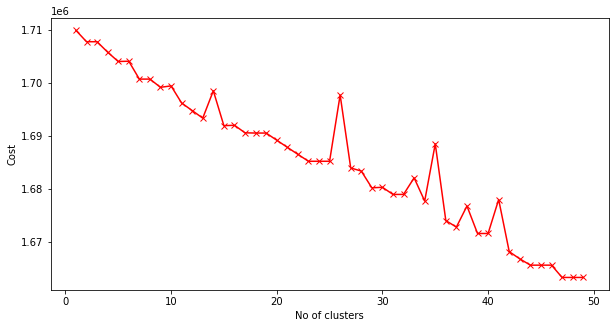

In [31]:
import matplotlib.pyplot as plt

# Plotting the costs
plt.figure(figsize=(10,5))
plt.plot(K, costs, 'rx-')
plt.xlabel('No of clusters')
plt.ylabel('Cost')
plt.show()

The cost is seen to decrease continuously as the number of clusters increases and kind of saturates after k = 46. So, 48 is chosen as the optimal number of clusters.

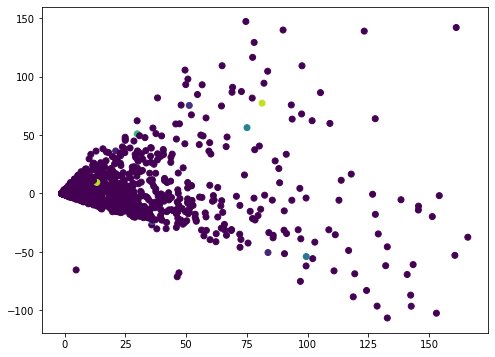

In [65]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

kmeans = KMeans(k = 48, init_method = "kmeans++")
kmeans.train(X = bow, max_iter = 1000000)

#Reducing datapoints to 2D and plotting the clusters
bow2D = PCA(n_components = 2).fit_transform(bow)
plt.figure(figsize=(8, 6))
plt.scatter(bow2D[:,0], bow2D[:,1], c = kmeans.cluster_assignments.astype(float))

### 2.4 1D KMeans (20 points)

Please implement 1D KMeans using the dynamic-programming solution discussed in class. Your code should mimic the code above (however be fit to being 1d).

In [35]:
import sys
import numpy as np

class OneDimKMeans(object):
    def __init__(self, k: int) -> None:
        self.k: int = int(k)
        self.D = None # Cost matrix
        self.B = None # Choice matrix
        self.centers = None
        self.splits = None # To track where splits occur
        self.cluster_assignments = None # Track cluster assignments

    def assign(self, X: np.ndarray, splits) -> None:
        self.cluster_assignments = []
        assignment = 0
        for i in range(X.shape[0]):
            self.cluster_assignments.append(assignment) # Assign clusters based on splits
            if(i in splits):
                assignment += 1
    
    def centers(self, X: np.ndarray, splits) -> None:
        self.centers: np.ndarray = np.empty((self.k))
        start = 0
        for i in range(self.k - 1):
            self.centers[i] = np.mean(X[start:splits[i] + 1]) # Assign mean of the clusters as centres
            start = splits[i] + 1
        self.centers[k] = np.mean(X[start:])
        
    
    def unit(self, X : np.ndarray) -> float:
        return sum([((X[i] - np.mean(X))**2) for i in range(X.shape[0])])
    


    def train(self, X: np.ndarray) -> None:
        
        self.D = np.zeros((X.shape[0], self.k))
        self.B = np.full((X.shape[0], self.k), -1)
        
        for i in range(X.shape[0]):
            self.D[i,0] = self.unit(X[0:i+1]) # Initialize first column (when the number of clusters is 1)
        
        for col in range(1, self.k):
            for row in range(col + 1, X.shape[0]):
                self.D[row, col] = sys.float_info.max
            for row in range(col + 1, X.shape[0]):
                for row_ind in range(row):
                    if self.D[row, col] > self.D[row_ind, col - 1] + self.unit(X[row_ind + 1:row + 1]):
                        self.D[row, col] = self.D[row_ind, col - 1] + self.unit(X[row_ind + 1:row + 1]) # Set to minimum cost
                        self.B[row, col] = row_ind # Store choice
                    
        ind = self.B[X.shape[0]-1, self.k-1] # The last split is at B[n,k]
        self.splits = []
        self.splits.append(self.B[X.shape[0]-1, self.k-1])
        for col in range(self.k - 2, 0, -1):
            self.splits.append(self.B[ind, self.k-2]) # Find all splits
            ind = self.B[ind, self.k-2]
            
        self.assign(X, self.splits)

### 2.5 Test Your Implementation (20 points)

Use PCA to reduce the data from section 2.1 into 1D, and use your 1D Kmeans implementation to produce cluster assignments using the same value of $k$ as from 2.3. If we let $C_0$ be the kmeans++ cluster assignments from 2.3, and let $C_1$ be the cluster assignments from your 1D Kmeans, we can compute the *disagreement* between the two clustering algorithms as, for any two movies $x$, and $y$:

$$I_{C_0, C_1}(x,y) = \begin{cases}
1 & \text{if } C_0(x) = C_0(y) \text{ and } C_1(x) \neq C_1(y)\\
  & \text{or } C_0(x) \neq C_0(y) \text{ and } C_1(x) = C_1(y)\\\\
0 & \text{otherwise}
\end{cases}$$

Compute the disagreement between the two clustering algorithms as $D(C_0, C_1) = \sum\limits_{x,y} I_{C_0,C_1}(x,y)$. What is the disagreement?

In [40]:
# Reducing datapoints to 1D
bow1D = PCA(n_components = 1).fit_transform(bow)
sort_index = np.argsort(bow1D)
bow1D = np.sort(bow1D)
kmeans1D = OneDimKMeans(k = 48)
kmeans1D.train(X = bow1D)

actualAssignments = np.empty((X.shape))
for i in range(bow1D.shape[0]):
    actualAssignments[sort_index[i]] = kmeans1D.cluster_assignments[i] # To assign clusters to data points before sorting


# Calculate disagreement distance
distance = 0
for i in range(kmeans.cluster_assignments.shape[0]):
    for j in range(i+1, len(kmeans.cluster_assignments.shape[0])):
        if kmeans.cluster_assignments[i] == kmeans.cluster_assignments[j] and actualAssignments[i] != actualAssignments[j]: # If nD and 1D point clusters disagree
            distance += 1
        elif kmeans.cluster_assignments[i] != kmeans.cluster_assignments[j] and actualAssignments[i] == actualAssignments[j]: # If nD and 1D point clusters disagree 
            distance += 1

print("Disagreement distance = ", distance)

Disagreement distance = 153570581
